## 서포트 벡터 머신
* **이번 주 강의는 슬라이드와 아래 그림을 참고로 보기 바랍니다.** 
* **코드가 이해 안되는 부분은 넘어가도 됩니다.**
* **아래에서 사이킷런을 이용한 서포트 벡터 회귀(support vector regressor)사용법은 익혀두기 바랍니다.**

In [1]:
import numpy as np
from sklearn.svm import SVR
from sklearn import datasets, svm, linear_model
from sklearn.datasets.samples_generator import make_circles
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from IPython.display import HTML, Image
import matplotlib.pyplot as plt


%matplotlib inline

C:\Users\WoongheeLee\miniconda3\envs\aifs\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
iris = datasets.load_iris()

In [3]:
X, y = iris['data'], iris['target']

In [4]:
X0 = X[:, 0]
X1 = X[:, 1]

In [5]:
setosa = np.where(y == 0)

In [6]:
versicolor = np.where(y == 1)

In [7]:
virginica = np.where(y == 2)

In [8]:
figsize=(10,5)
dpi = 160
xlim = (np.min(X0)-.5, np.max(X0)+.5)
ylim = (np.min(X1)-.5, np.max(X1)+.5)

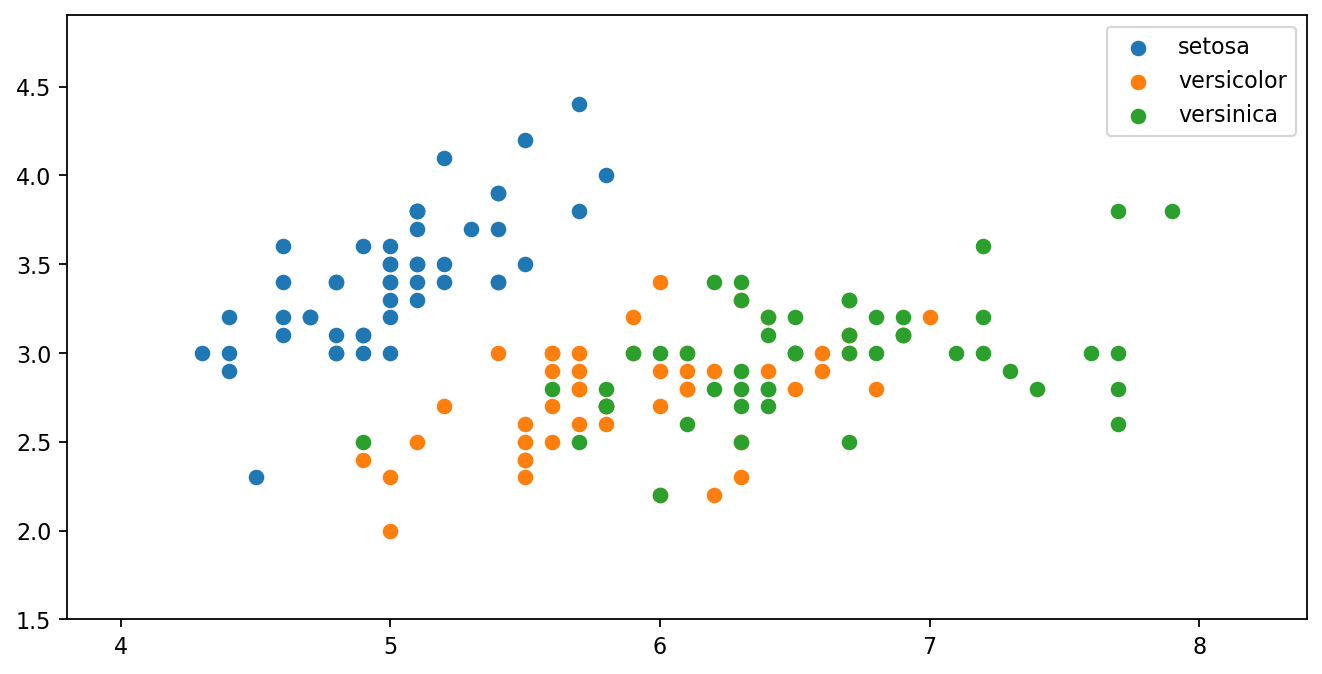

In [9]:
plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(X0[setosa], X1[setosa], label='setosa')
plt.scatter(X0[versicolor], X1[versicolor], label='versicolor')
plt.scatter(X0[virginica], X1[virginica], label='versinica')
plt.legend()
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

* Setosa과 다른 품종을 분류하는 분류기를 만든다면 무수히 많은 분류기를 만들 수 있음

In [10]:
# X, y = make_blobs(n_samples=40, centers=2, random_state=0)
X = np.concatenate([np.expand_dims(X0,axis=-1), np.expand_dims(X1,axis=-1)],axis=-1)
y = np.array([int(_y) for _y in iris.target == 0])

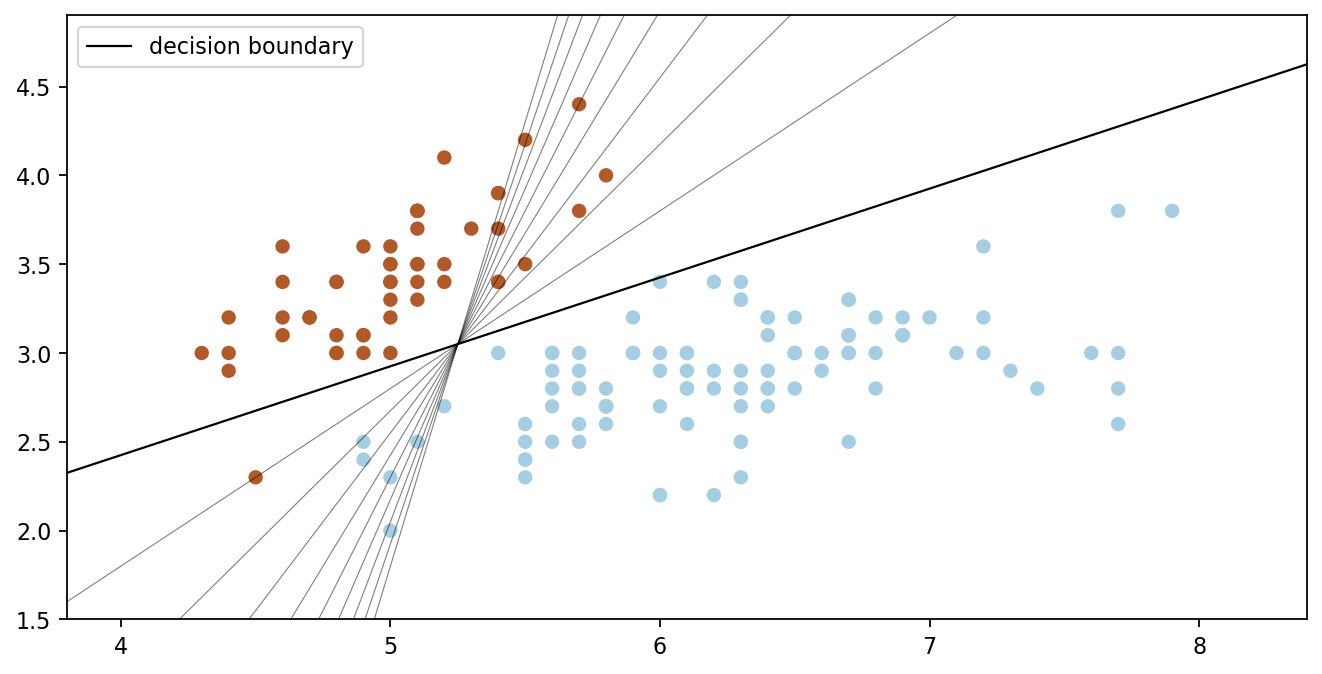

In [11]:
_x = np.linspace(np.min(X0)-.5, np.max(X0)+.5, 100)

N = 10
f = list()
for i in range(N):
    _f = lambda x: (i*.5+.5)*(x - 5.25) + 3.05
    f.append(_f)

plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

for i in range(N):
    if i == 0:
        plt.plot(_x, f[i](_x), color='k', label='decision boundary', linewidth=1)
    else:
        plt.plot(_x, f[i](_x), color='k', linewidth=.5, alpha=.5)
plt.legend(loc=2)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

* SVM 은 이 중에서 서포트 벡터들 사이의 마진이 가장 크게 하는 decision boundary를 찾는 것이 목표
* Support vectors는 decision boundary 와 가장 가까운 데이터 포인트(N차원 상에서 데이터 포인트 각각은 벡터이기도 함)

In [12]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_blobs

In [13]:
C = 10000
clf = LinearSVC(C=C, verbose=2, max_iter=1e5, random_state=0)
clf.fit(X, y)

[LibLinear]

LinearSVC(C=10000, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=100000.0,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=2)

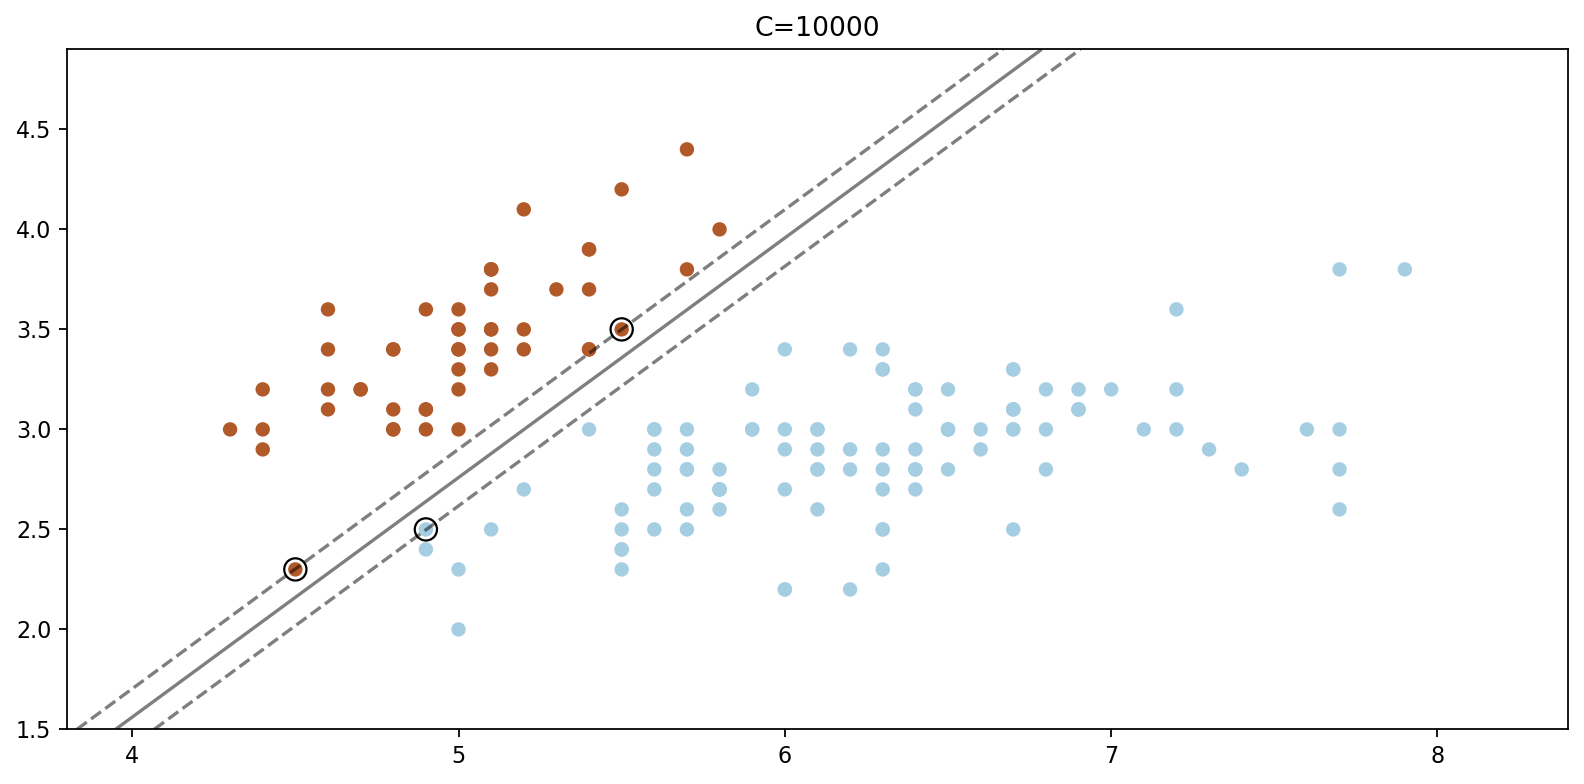

In [14]:
plt.figure(figsize=figsize, dpi=dpi)

decision_function = clf.decision_function(X)

support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
support_vectors = X[support_vector_indices]

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
ax = plt.gca()


xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                    np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=.5, linestyles=['--','-','--'])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, linewidth=1, facecolors='none', edgecolor='k')
plt.title("C=" + str(C))

plt.xlim(xlim)
plt.ylim(ylim)
    
plt.tight_layout()
plt.show()

## 커널 매핑
* 자주 사용하는 커널 매핑 함수를 시각화하여 어떤 기능을 하는지 확인

(코드 참고 출처: [https://xavierbourretsicotte.github.io/Kernel_feature_map.html])

**아래 그림과 같은 데이터 포인트가 있을 때, 커널 매핑으로 선형 분리 해보자.**

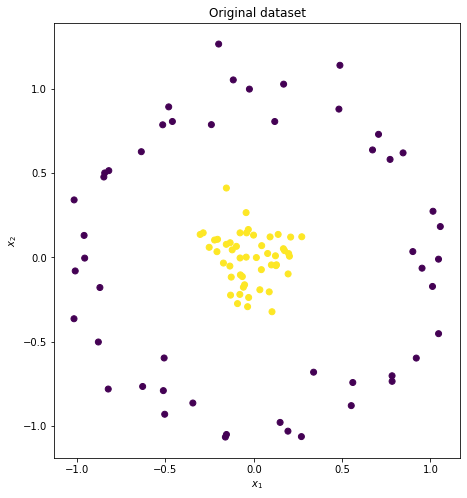

In [15]:
X, y = make_circles(100, factor=.1, noise=.1)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

plt.show()

### 방법 1. 선형 서포트 벡터 머신
* 2차원 데이터 포인트가 주어질 째, 각각의 차원을 단순 곱해서 셋째 차원으로 만듦
$$
\phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^T x_2)
$$

In [16]:
def feature_map_1(X):
    return np.asarray((X[:,0], X[:,1], np.multiply(X[:,0], X[:,1]))).T

* 결과를 보면 선형 분리 가능하도록 매핑이 잘 안됨

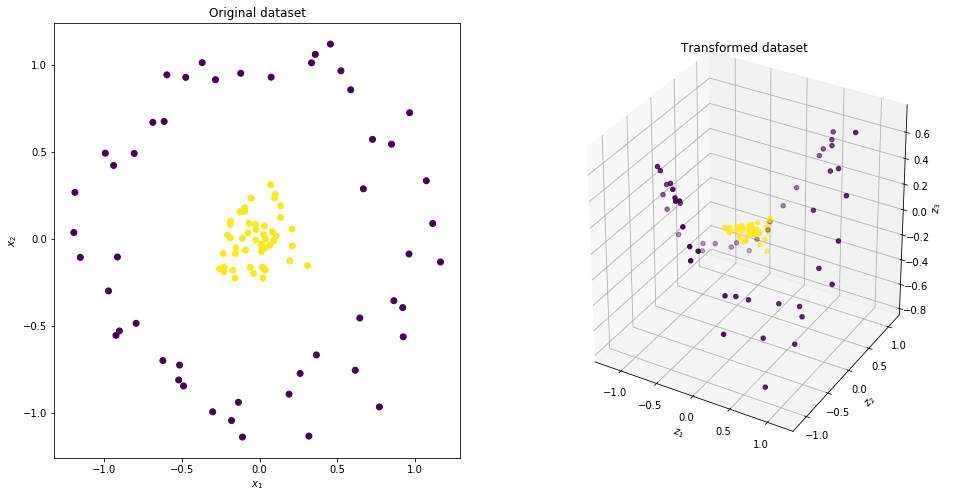

In [17]:
X, y = make_circles(100, factor=.1, noise=.1)
Z = feature_map_1(X)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')

plt.show()

### 방법 2. 다항식 합 (sum of polynomials)
* 2차원 데이터 포인트가 주어질 때, 각각의 차원에 제곱합을 셋째 차원으로 만들어줌
$$
\phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^2 + x_2^2)
$$

In [18]:
def feature_map_2(X):
    return np.asarray((X[:,0], X[:,1], X[:,0]**2 + X[:,1]**2)).T

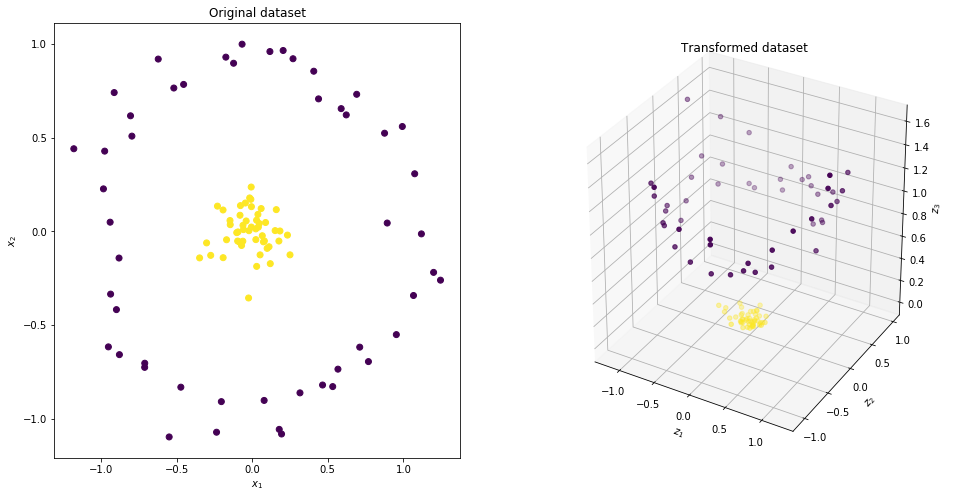

In [19]:
X, y = make_circles(100, factor=.1, noise=.1)
Z = feature_map_2(X)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')

plt.show()

### 방법 3. Gaussian Radial Basis Function (RBF) centered at 0, 0
2차원 데이터 포인트가 주어질 때, 각각의 차원의 제곱합의 음수를 자연상수 $e$에 제곱해서 셋째 차원으로 만들어줌
$$
\phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, \exp(-|x_1^2 + x_2^2|))
$$
이 때,

$$
exp(x) = e^x
$$

In [20]:
def feature_map_3(X):  
    return np.asarray((X[:,0], X[:,1], np.exp( -( X[:,0]**2 + X[:,1]**2)))).T

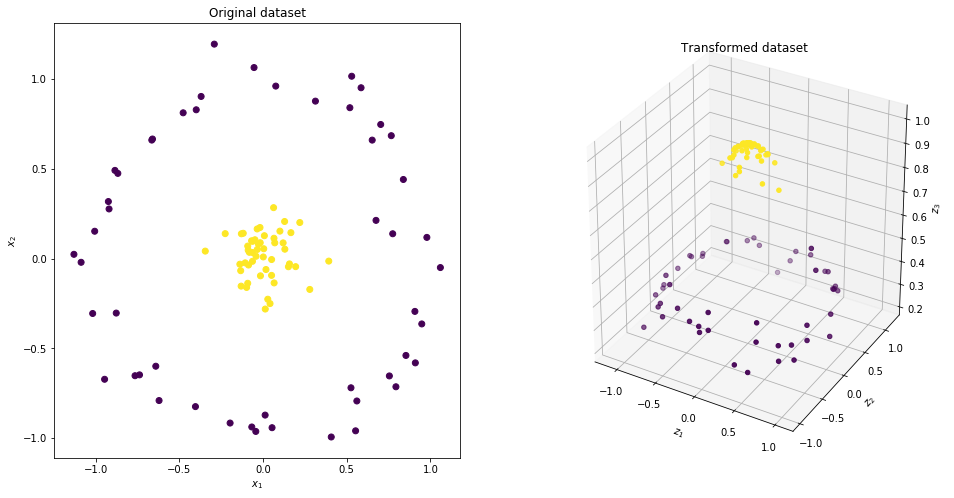

In [21]:
X, y = make_circles(100, factor=.1, noise=.1)
Z = feature_map_3(X)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')
plt.show()

### 방법 4. 시그모이드 커널
* 2차원 데이터 포인트가 주어질 때, 각 차원의 값의 곱에 대한 하이퍼 탄젠트 값을 셋째 차원으로 만듦
$$
\phi(x_1, x_2) = (z_1, z_2, z_3) = \tanh (\gamma(x_1^T x_2)+\theta))
$$

In [22]:
def feature_map_4(X):
    gamma = 1.
    theta = 1.
    return np.asarray((X[:,0], X[:,1], np.tanh(np.multiply(X[:,0], X[:,1])))).T

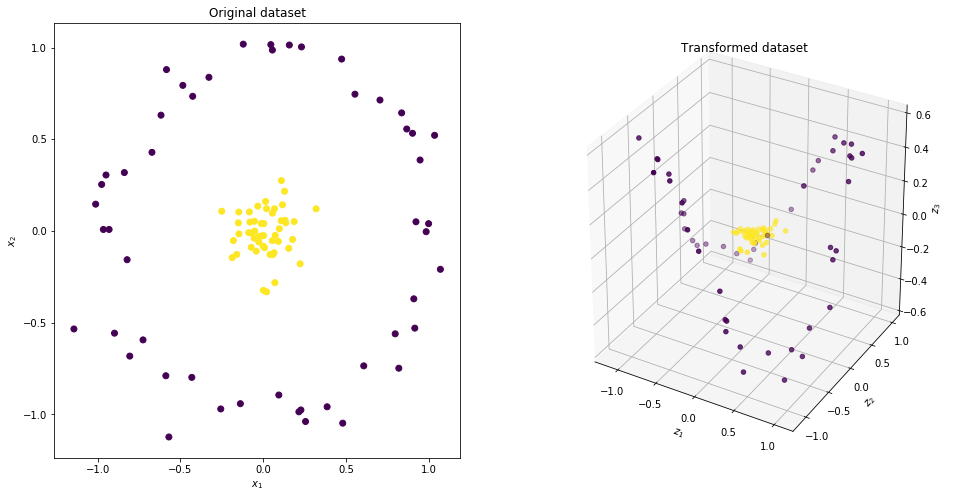

In [23]:
X, y = make_circles(100, factor=.1, noise=.1)
Z = feature_map_4(X)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')
plt.show()

### 방법 5. 다항 커널
$$
K(x, x') = (x^T x')^d
$$

$d = 2$ 이고 $x=(x_1, x_2)^T$ 라고 하자. 그러면,

$$
\begin{align}
k(x, x') & = (x_1 x_1' + x_2 x_2')^2\\
& = 2x_1 x_1' x_2 x_2' + (x_1 x_1')^2 + (x_2 x_2')^2\\
& = (\sqrt{2}x_1x_2x_1^2x_2^2) (\sqrt{2}x_1'x_2' x_1^{'2} x_2^{'2})^T
\end{align}
$$

$$
k(x, x') = \phi(x)^T \phi(x')
$$

이 때,
$$
\phi(x_1, x_2) = (\sqrt{2}x_1x_2, x_1^2, x_2^2)
$$

아래 함수를 구현한다.

$$
x_1, x_2 :\rightarrow z_1, z_2, z_3
$$
$$
z_1 = \sqrt{2}x_1x_2, z_2 = x_1^2, z_3 = x_2^2
$$

In [24]:
def feature_map_5(X):  
    return np.asarray(( np.sqrt(2) *X[:,0] * X[:,1], X[:,0]**2, X[:,1]**2)).T

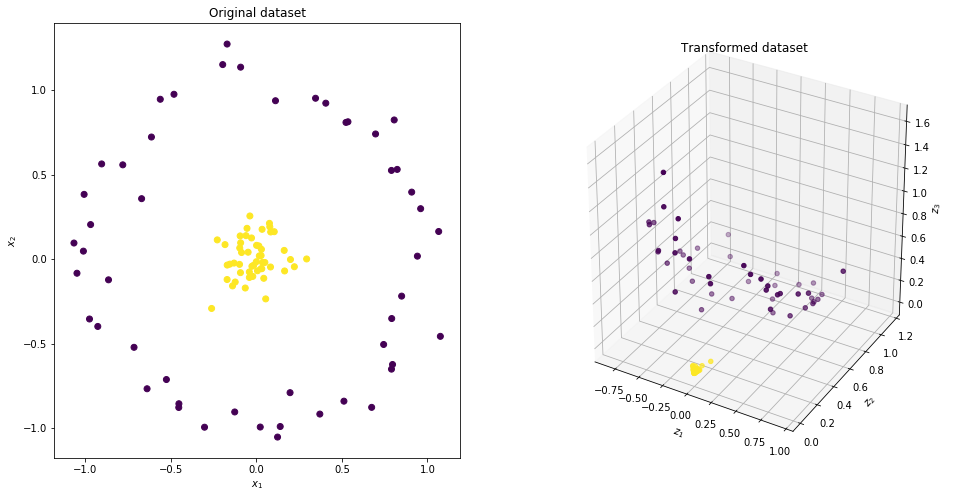

In [25]:
X, y = make_circles(100, factor=.1, noise=.1)
Z = feature_map_5(X)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = y, cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')
plt.show()

## 선형 회귀

In [26]:
# 데이터 불러오기
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 2]

# 학습용과 테스트용 나누기
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

In [27]:
# 모델 클래스 생성
regr = linear_model.LinearRegression()

# 모델 학습
regr.fit(diabetes_X_train, diabetes_y_train)

# 모델 예측
diabetes_y_pred = regr.predict(diabetes_X_test)

In [28]:
_x = np.linspace(-.09, .1, 100)
f = lambda x: regr.coef_* _x + regr.intercept_

In [29]:
print('선형 회귀 기울기',regr.coef_,', 절편',regr.intercept_)

선형 회귀 기울기 [938.23786125] , 절편 152.91886182616167


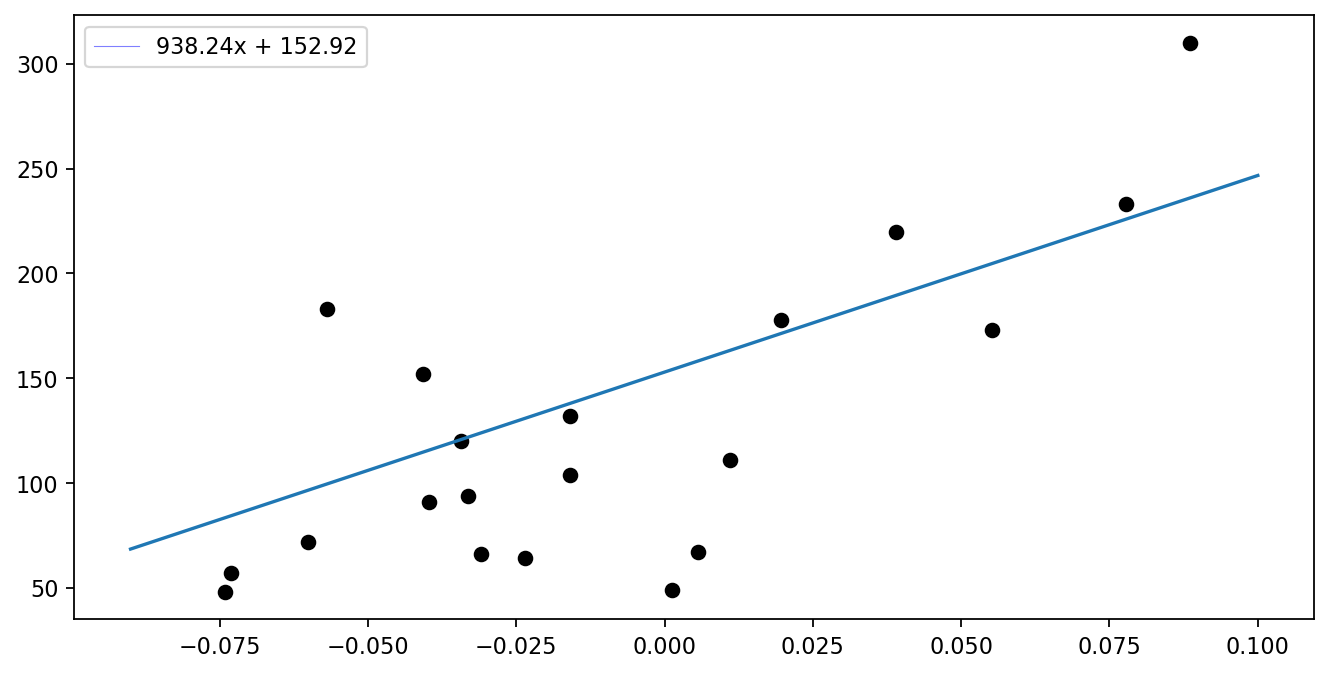

In [30]:
linear_regression = f"{regr.coef_[0]:.2f}x + {regr.intercept_:.2f}"
plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=.5, alpha=.5, label=linear_regression)
plt.plot(_x, f(_x))
plt.legend()
plt.show()

## 연습용 데이터 생성
* 사인 함수를 이용하여 비선형 데이터를 생성
* 몇 개의 데이터 포인트는 랜덤하게 값을 변형하여 노이즈를 만듦

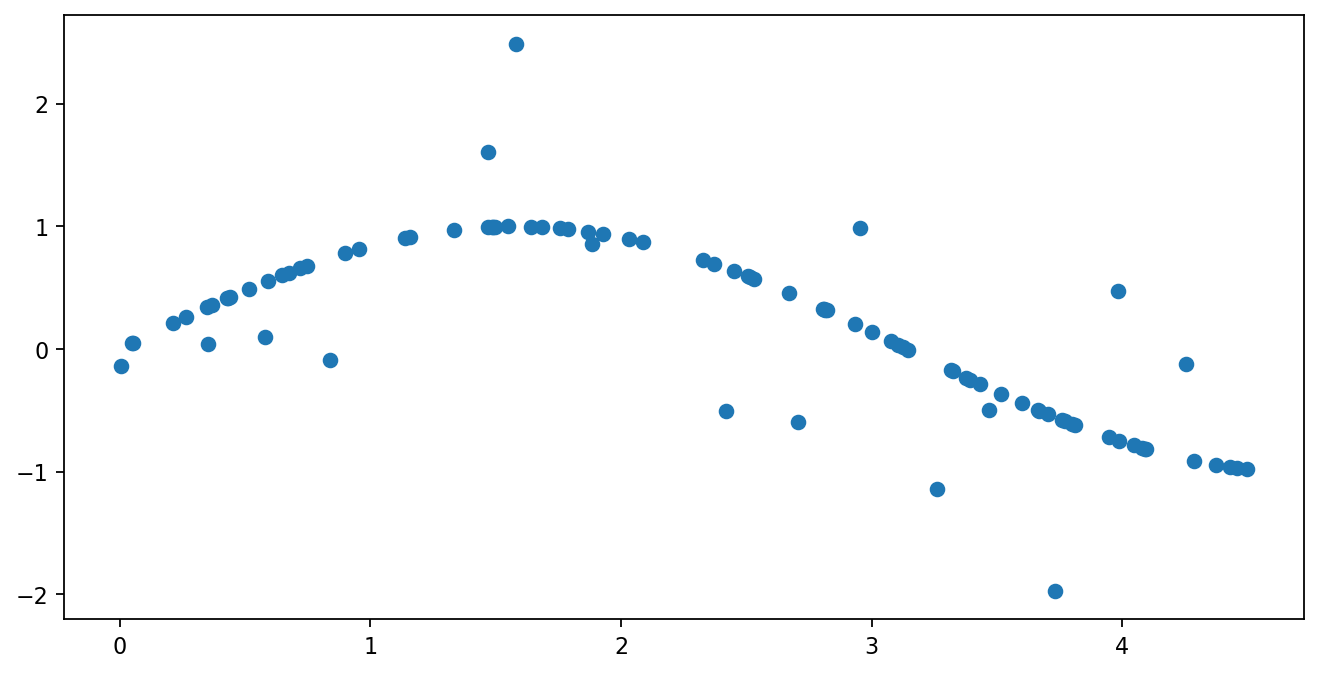

In [31]:
# 데이터 만들기
_len = 4.5
X = np.sort(_len * np.random.rand(90, 1), axis=0)
y = np.sin(X).ravel()

# 인덱스 몇 번에 한번씩 노이즈 주기
y[::6] += 3 * (0.5 - np.random.rand(90//6))

plt.figure(figsize=figsize, dpi=dpi)
plt.scatter(X, y)
plt.show()

## 서포트 벡터 회귀와 커널매핑

* 비선형 회귀 문제에 관해 알아보기
* 비선형 문제에서 커널 매핑 결과를 그려서 직관적으로 이해하기

In [32]:
X.shape, y.shape

((90, 1), (90,))

### 방법 1. Gaussian Radial Basis Function (RBF) centered at 0, 0

In [33]:
def kernel_rbf(X,y):
    _X = np.concatenate([X, np.expand_dims(y, axis=-1)], axis=-1)
    return np.asarray((_X[:,0], _X[:,1], np.exp( -( _X[:,0]**2 + _X[:,1]**2)))).T

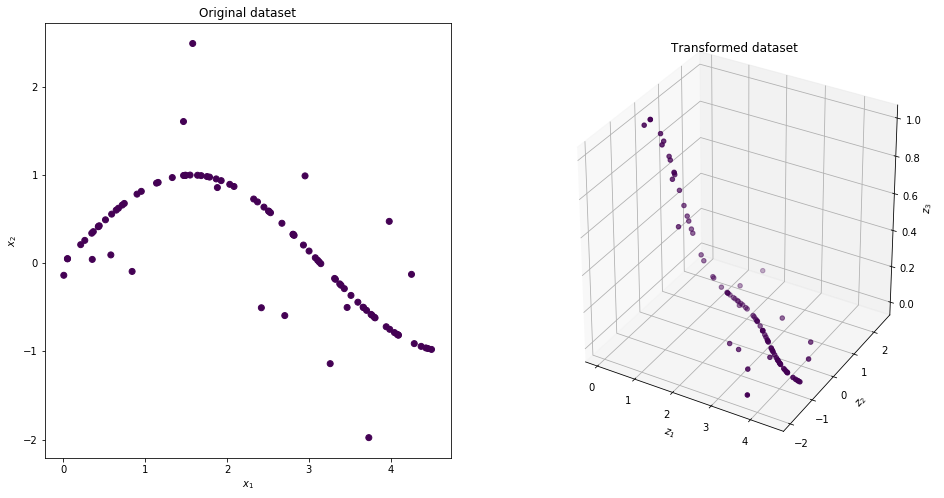

In [34]:
Z = kernel_rbf(X, y)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X, y, c = np.ones(y.shape), cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = np.ones(y.shape), cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')
plt.show()

### 방법 2. 선형 서포트 벡터 머신


In [35]:
def kernel_linear(X,y):
    _X = np.concatenate([X, np.expand_dims(y, axis=-1)], axis=-1)
    return np.asarray((_X[:,0], _X[:,1], np.multiply(_X[:,0], _X[:,1]))).T

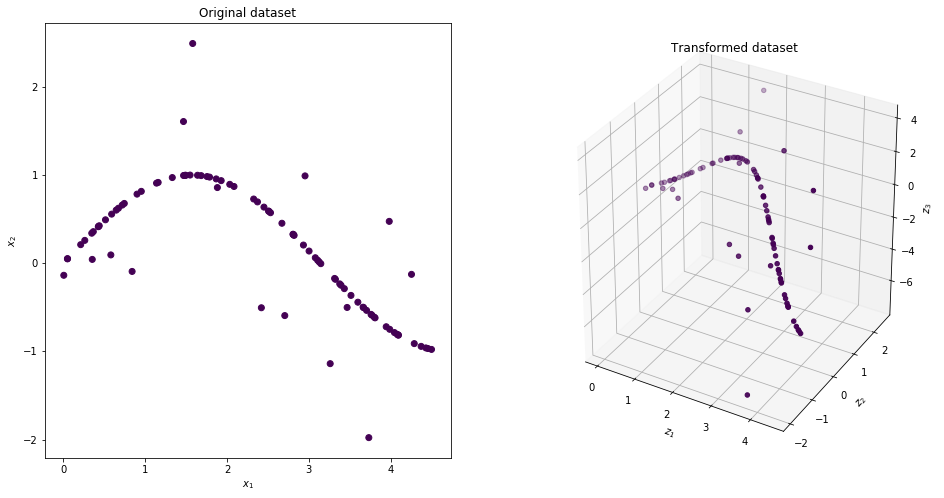

In [36]:
Z = kernel_linear(X, y)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X, y, c = np.ones(y.shape), cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = np.ones(y.shape), cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')
plt.show()

### 방법 3. 다항 커널


In [37]:
def kernel_poly(X,y):
    _X = np.concatenate([X, np.expand_dims(y, axis=-1)], axis=-1)
    return np.asarray(( np.sqrt(2) *_X[:,0] * _X[:,1], _X[:,0]**2, _X[:,1]**2)).T

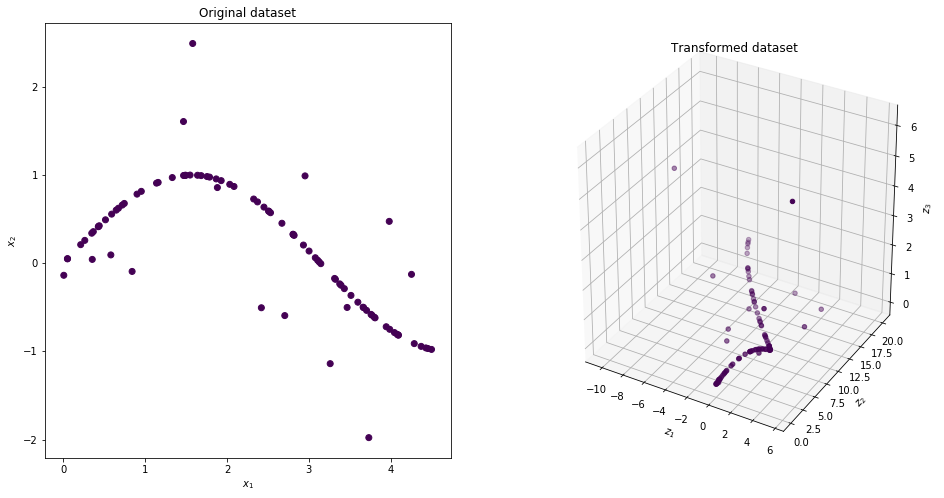

In [38]:
Z = kernel_poly(X, y)

#2D scatter plot
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X, y, c = np.ones(y.shape), cmap = 'viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original dataset')

#3D scatter plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(Z[:,0],Z[:,1], Z[:,2],c = np.ones(y.shape), cmap = 'viridis' ) #,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
ax.set_title('Transformed dataset')
plt.show()

## 각각의 커널을 이용한 서포트 벡터 회귀 모델 학습 결과
* 참고 코드 : [https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html]

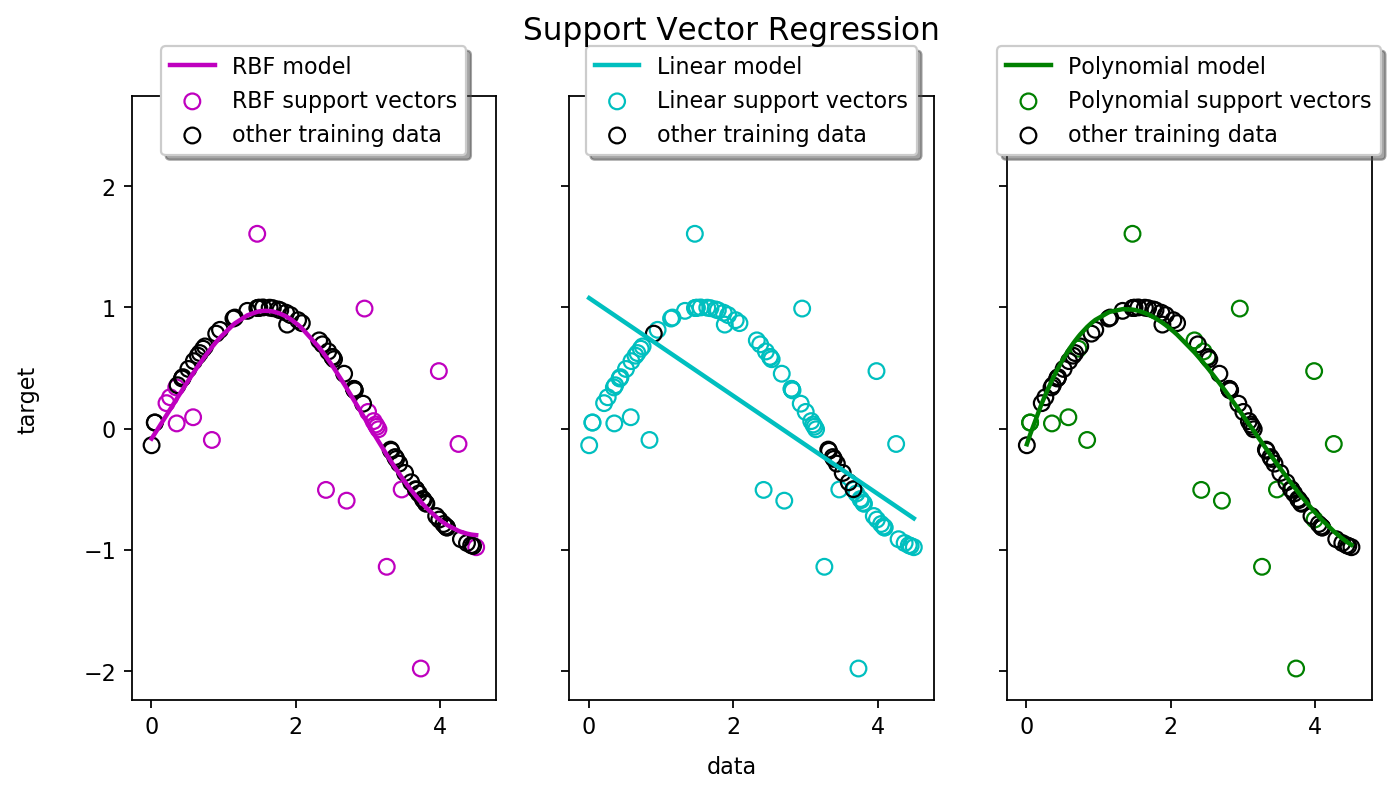

In [39]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize, dpi=dpi, sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

## 사이킷 런 서포트 벡터 회귀 (support vector regressor) 사용법
* **이곳 코드부터 따라해보시고, 사용법을 익히기 바랍니다.**

In [40]:
# sklearn.svm 모듈로부터 SVR 클래스 불러옴
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

(데이터 만드는 코드에서 이해가 안되면 넘어가도 됨)

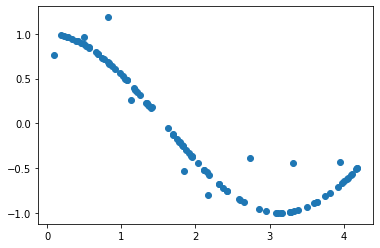

In [41]:
# 0 부터 pi 값 사이에 랜덤한 데이터 여러 개 찍음
_len = 4/3*np.pi
X = np.sort(_len * np.random.rand(100, 1), axis=0)
# X에 해당하는 y는 cosine 함수
y = np.cos(X).ravel()
# 몇 개에 한 번 노이즈 주기
y[::10] += 1.1 * (0.5 - np.random.rand(100//10))

# 데이터 그려보기
plt.scatter(X, y)
plt.show()

In [42]:
# 학습 데이터와 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.80, shuffle=True, random_state=0)

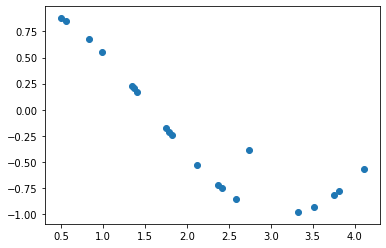

In [43]:
# 학습 데이터 그려보기
plt.scatter(X_train, y_train)
plt.show()

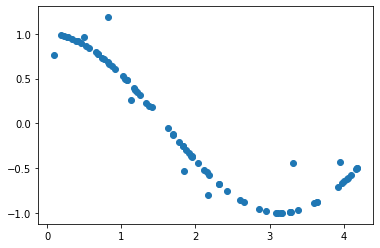

In [44]:
# 테스트 데이터 그려보기
plt.scatter(X_test, y_test)
plt.show()

In [45]:
# 학습 데이터와 테스트 데이터 개수 알아보기
X_train.shape, X_test.shape

((20, 1), (80, 1))

In [46]:
# 모델 사용을 위한 클래스 생성
svr = SVR()

In [47]:
# 모델 학습
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [48]:
# 학습한 결과 확인
y_pred = svr.predict(X_test)

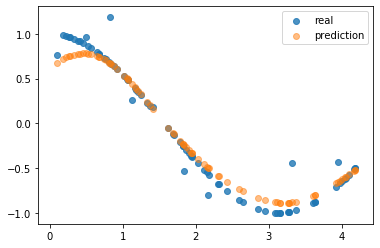

In [49]:
plt.scatter(X_test, y_test, label='real', alpha=.8)
plt.scatter(X_test, y_pred, label='prediction', alpha=.5)
plt.legend()
plt.show()

## 과적합(overfitting) vs. 과소적합(under fitting)
* 직접 구현해서 어떤 일이 생기나 확인

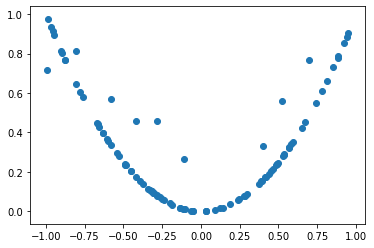

In [50]:
# 0 부터 pi 값 사이에 랜덤한 데이터 여러 개 찍음
_len = 2
X = np.sort(_len * np.random.rand(100, 1)-1, axis=0)
# X에 해당하는 x^2 함수
f = lambda x: x**2
y = f(X).ravel()
# 몇 개에 한 번 노이즈 주기
y[::10] += 1.1 * (0.5 - np.random.rand(100//10))

# 데이터 그려보기
plt.scatter(X, y)
plt.show()

In [51]:
# 학습 데이터와 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.80, shuffle=True, random_state=1)

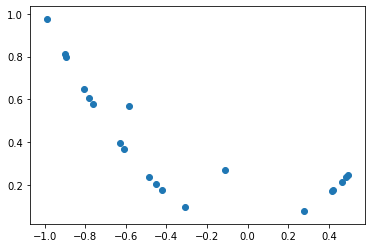

In [52]:
# 학습 데이터 그려보기
plt.scatter(X_train, y_train)
plt.show()

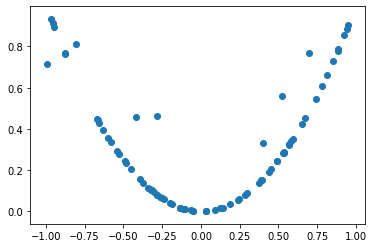

In [53]:
# 테스트 데이터 그려보기
plt.scatter(X_test, y_test)
plt.show()

### 과적합(overfitting)
* 데이터에 비해 모델이 너무 복잡(차수가 높은 모델)한 경우 발생

In [54]:
from sklearn.svm import SVR

In [55]:
# 다차 함수로 된 모델 생성
svr_overfitting = SVR(kernel='poly', degree=5, verbose=2)

In [56]:
%%time
# 복잡한 모델 (차수가 높은 모델)이라 학습에 오랜 시간 소요
svr_overfitting.fit(X_train, y_train)

[LibSVM]Wall time: 4.99 ms


SVR(C=1.0, cache_size=200, coef0=0.0, degree=5, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=2)

In [57]:
y_pred = svr_overfitting.predict(X_test)

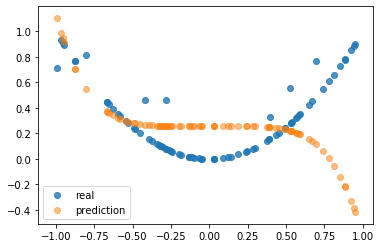

In [58]:
plt.scatter(X_test, y_test, label='real', alpha=.8)
plt.scatter(X_test, y_pred, label='prediction', alpha=.5)
plt.legend()
plt.show()

## 과소적합(under fitting)
* 데이터 복잡도보다 모델 복잡도가 너무 단순한 경우 발생

In [59]:
# 1차 함수 모델
svr_underfitting = SVR(kernel='poly', degree=1, verbose=2)

In [60]:
svr_underfitting.fit(X_train, y_train)

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=2)

In [61]:
y_pred = svr_underfitting.predict(X_test)

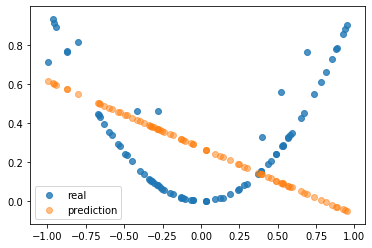

In [62]:
plt.scatter(X_test, y_test, label='real', alpha=.8)
plt.scatter(X_test, y_pred, label='prediction', alpha=.5)
plt.legend()
plt.show()

In [63]:
# 적당한 함수 모델
svr_goodfitting = SVR(kernel='poly', degree=2, verbose=2)

In [64]:
svr_goodfitting.fit(X_train, y_train)

[LibSVM]

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=2)

In [65]:
y_pred = svr_goodfitting.predict(X_test)

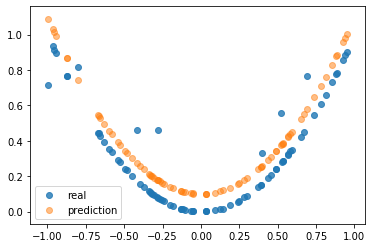

In [66]:
plt.scatter(X_test, y_test, label='real', alpha=.8)
plt.scatter(X_test, y_pred, label='prediction', alpha=.5)
plt.legend()
plt.show()

## 모델 평가

* 회귀 모델의 모델 평가는 예측해야할 값과 예측한 값의 차이로 평가함
* 사용법은 분류모델 평가방법과 동일
  * 평가법(실제값, 예측값)

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

* 평균 절대값 오차 (mean absolute error): 실제 값과 모델이 예측한 값 사이의 절대 오차의 평균을 구한 것
$$
MAE = {\sum_i^N |y_i -\hat{y}_i|\over N}
$$

* 이 때, $N$은 데이터 포인트 개수, $\hat{y}$ 는 예측값

* 0이 최고 좋음

In [68]:
mean_absolute_error(y_test, y_pred)

0.10823011553706845

* 평균 오차 제곱(mean squared error): 실제 값과 모델이 예측한 값 사이의 오차 제곱의 평균
$$
MSE = {\sum_i^N (y_i -\hat{y}_i)^2  \over N}
$$
* 0이 최고 좋음

In [69]:
mean_squared_error(y_test, y_pred)

0.013296161960289186

* R-square: 다음 수식에 따라 정의 함
$$
1 - (\mbox{모델이 예측한 값에 관한 MSE}) / (\mbox{데이터의 평균 값에 관한 MSE})
$$

* 1이 최고 좋음

In [70]:
r2_score(y_test, y_pred)

0.8370649190519768